In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [94]:
class Cellular_plots_model:

    def __init__(self, n_steps, n_types, n_cells, nx=40, T=1, k=0.5, lamda=1, equilibrium_area=5):

        self.n_steps = n_steps
        self.n_types = n_types
        self.n_cells = n_cells

        self.nx = nx
        self.T = T
        self.k = k
        self.lamda = lamda
        self.equilibrium_area = equilibrium_area
        
        # key: cell_ID, value: cell_size
        self.cell_sizes = {0: nx*nx}
        
        self.initialize_grid()

        self.step = 0
        # self.hamiltonian = self.calc_hamiltonian(self.grid)

    def initialize_grid(self):
        
        # Cells are stored on a 3D grid, where the first two dimensions are spatial
        # and the third dimension stores the cell ID and type
        self.grid = np.zeros((self.nx + 2, self.nx + 2, 2), dtype=int)


        for cell_ID in range(1, self.n_cells + 1):

            # Pick a random latice site which is not yet occupied
            while True:

                # Pick random lattice site
                i, j = np.random.randint(1, self.nx, 2)

                if self.grid[i, j, 0] == 0:
                    break
                
            cell_type = np.random.choice(np.arange(1, self.n_types))

            self.grid[i, j, 0] = cell_ID
            self.grid[i, j, 1] = cell_type
            self.cell_sizes[cell_ID] = 1
            
    def run(self):
        
        while self.step < self.n_steps:
            self.update()

            if self.step % 100 == 0:
                print(f"Step: {self.step}", end="\r")
    
    def update(self):

        # Pick random lattice site
        i, j = np.random.randint(1, self.nx, 2)
        cell_ID = self.grid[i, j, 0]
        cell_type = self.grid[i, j, 1]

        # Pick a random neighbour
        von_neumann_neighbourhood = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j-1)]
        von_neumann_index = np.random.randint(0, len(von_neumann_neighbourhood))
        neighbour_i, neighbour_j = von_neumann_neighbourhood[von_neumann_index]

        neighbour_ID = self.grid[neighbour_i, neighbour_j, 0]
        neighbour_type = self.grid[neighbour_i, neighbour_j, 1]

        if cell_ID == neighbour_ID:
            self.step += 1
            return

        grid_sliced = self.grid[i - 1 : i + 2, j - 1: j + 2]
        grid_sliced_copy = grid_sliced.copy()
        grid_sliced_copy[1, 1, 0] = neighbour_ID
        grid_sliced_copy[1, 1, 1] = neighbour_type

        old_ham_vol = self.calc_hamiltonian_vol()

        self.cell_sizes[neighbour_ID] += 1
        self.cell_sizes[cell_ID] -= 1

        new_ham_vol = self.calc_hamiltonian_vol()

        delta_ham_bond = self.calc_delta_hamiltonian_bond(self.grid, i, j, cell_ID, cell_type, neighbour_ID, neighbour_type)

        delta_hamiltonian = (new_ham_vol - old_ham_vol) + delta_ham_bond
        
        if delta_hamiltonian < 0 or np.random.uniform() < np.exp(-delta_hamiltonian/(self.k * self.T)):
            
            # Update grid
            self.grid[i, j, 0] = neighbour_ID
            self.grid[i, j, 1] = neighbour_type
            # self.hamiltonian = self.calc_hamiltonian(self.grid)


        else:
            self.cell_sizes[neighbour_ID] -= 1
            self.cell_sizes[cell_ID] += 1

        self.step += 1

    def calc_hamiltonian(self, grid):

        H_vol = self.calc_hamiltonian_vol()
        H_bond = self.calc_hamiltonian_bond(grid)

        return H_vol + H_bond
      
    def calc_hamiltonian_vol(self):

        sigma = 0
        for cell_ID in range(1, self.n_cells + 1):

            cell_area = self.cell_sizes[cell_ID]
            sigma += (cell_area - self.equilibrium_area) ** 2

        return self.lamda * sigma

    def calc_hamiltonian_bond(self, grid):

        H_bond = 0
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):

                H_bond += self.calc_hamiltonian_bond_local(grid, i, j)

        return H_bond

    def calc_delta_hamiltonian_bond(self, grid, i, j, cell_ID1, cell_type1, cell_ID2, cell_type2):

        old_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID1, cell_type1)
        new_ham = self.calc_hamiltonian_bond_new_implemetation(grid, i, j, cell_ID2, cell_type2)

        return 2 * (new_ham - old_ham)

    def calc_hamiltonian_bond_local(self, grid, i, j):

        H_bond = 0
        cell_ID = grid[i, j, 0]
        cell_type = grid[i, j, 1]
        
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset

                cell_prime_ID = grid[i, j, 0]
                cell_prime_type = grid[i_prime, j_prime, 1]

                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond

    def calc_hamiltonian_bond_new_implemetation(self, grid, i, j, cell_ID, cell_type):

        H_bond = 0
        for i_offset in [-1, 0, 1]:
            for j_offset in [-1, 0, 1]:

                if i_offset == 0 and j_offset == 0:
                    continue
                    
                i_prime = i + i_offset
                j_prime = j + j_offset
                
                cell_prime_ID = grid[i, j, 0]
                cell_prime_type = grid[i_prime, j_prime, 1]
                
                J = self.J(cell_type, cell_prime_type)
                kronecker_delta = self.kronecker_delta(cell_ID, cell_prime_ID)

                H_bond += J * (1 - kronecker_delta)

        return H_bond

    
    def J(self, type1, type2):

        if type1 == 0 or type2 == 0:
            return 0

        if type1 == type2:
            return 1

        return -1

    def kronecker_delta(self, value1, value2):

        if value1 == value2:
            return 1

        return 0
            
    def show_grid(self):

        grid = np.array(self.grid, dtype=float)

        # For plotting purposes set M cells to None
        grid[grid==0] = np.nan
        
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.matshow(grid[1:-1, 1:-1, 0], cmap='hsv')
        ax1.set_title("Cell IDs")

        ax2.matshow(grid[1:-1, 1:-1, 1], cmap="hsv")
        ax2.set_title("Cell types")
        
        plt.tight_layout()
        plt.show()

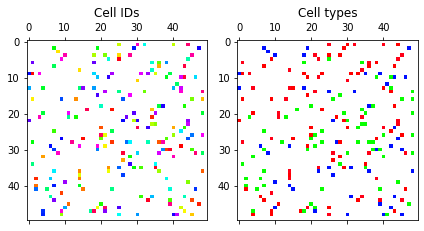

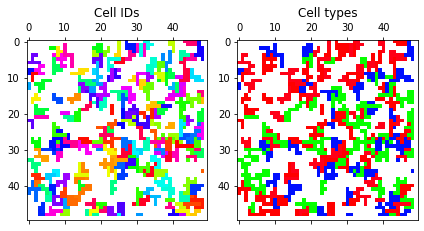

In [97]:
model = Cellular_plots_model(n_steps=10000, n_types=5, n_cells=200, nx=50, equilibrium_area=10)
model.show_grid()
model.run()
model.show_grid()